# **Statistics lecture 2 Hands-on session : solutions notebook**

This is the companion notebook to lecture 2 in the statistical course series, covering the following topics:
1. Maximum likelihood basics
2. Maximum likelihood for binned data
3. Maximum likelihood in the Gaussian case and chi2
4. Hypothesis testing basics

First perform the usual imports:

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

## 1.  Maximum likelihood basics

Maximum likelihood is a powerful tool to *estimate* (=compute the value of, in stats parlance) unknown parameters. The principle is as follows: what we know is
* **The PDF** $P(x;\theta)$, in terms of the observable $x$ (a.k.a. the random variable) and one or more unknown parameters $\theta$.
* **A dataset**, i.e. a value $x_{\text{obs}}$ of the observable.

The natural usage of the PDF is to draw values of $x$, for a given value of $\theta$. What we need here is the reverse: we already have the observed $x_{\text{obs}}$, and we'd like to use it to infer the value of $\theta$.

Maximum likelihood (ML) is the procedure of doing this by maximizing the PDF as a function of $\theta$ and with the observable fixed to to $x = x_{\text{obs}}$. This presentation of the PDF is called the *likelihood*, and it's really still just the PDF:
$$
L(\theta) = P(x_{\text{obs}}; \theta).
$$
The ML estimator for $\theta$ is then
$$
\hat{\theta} = \text{arg max}_{\theta} \, L(\theta),
$$
the value of $\theta$ that maximizes $L$.

We start with a simple example: a counting experiment where we observe $n=5$ with an expected background of $b=3$. The PDF is a Poisson, with a parameter given as $s+b$, and we'd like to estimate $s$.

The ML procedure is performed as

hat{s}, ML = (2.0, 0.17546736976785068)


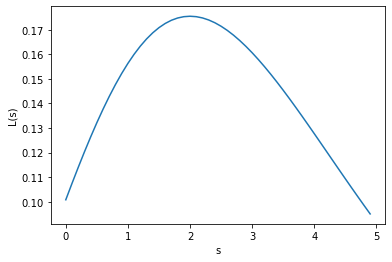

In [25]:
# Set the inputs
n_obs = 5
b = 3

# We're going to scan values of s ranging from 0 to 5, in steps of 0.1
s_values = np.arange(0, 5, 0.1)

# Compute the corresponding values of the likelihood (=the PDF), and plot the result
l_values = [ scipy.stats.poisson.pmf(n_obs, s+b) for s in s_values ] # compute the likelihood (the Poisson PDF for each s)
plt.plot(s_values, l_values)
plt.xlabel('s')
plt.ylabel('L(s)')

# Find the maximum likelihood value in the list : merge the 2 lists and find the max based on the second value (L)
from operator import itemgetter
print('hat{s}, ML =', max( [ (s,l) for s,l in zip(s_values, l_values) ], key=itemgetter(1)))

So the maximum is indeed at $\hat{s} = 2$, and all of this works as expected, at least in this simple example.

Note that while the position of the maximum is meaningful, the likelihood value isn't: as we'll see later, likelihoods only need to be defined up to a multiplicative factor since we only use likelihood ratios in measurements, so their absolute value is arbitrary.


## 2. Maximum likelihood for binned data

To make things a bit more interesting, we move to the analysis of binned data. We take a model similar to the one used for the $\chi^2$ exercise in the previous lecture:

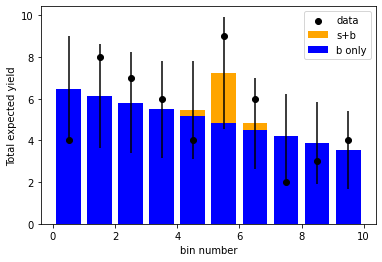

In [27]:
# Define the binning
nbins = 10
x = np.linspace(0.5, nbins - 0.5, nbins)

# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_fracs = b_yields/np.sum(b_yields)

# The signal shape is a peak
s_fracs = np.zeros(nbins)
s_fracs[4:7] = [ 0.1, 0.8, 0.1 ]

# Define the signal and background
s = 3
b = 50
s_and_b = s*s_fracs + b*b_fracs
b_only = b*b_fracs

# Now generate some data for the s+b model
np.random.seed(14) # Set the random seed to make sure we generate the same data every time
data = [ np.random.poisson(s*s_frac + b*b_frac) for s_frac, b_frac in zip(s_fracs, b_fracs) ]

# Make a plot of the result
plt.bar(x, s_and_b, color='orange', yerr=np.sqrt(s_and_b), label='s+b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

The plot above shows the typical case of a binned analysis: we have 2 *templates*, i.e. reference shapes for signal and background. These are given by bin fractions $f_{S,i}$ and $f_{B,i}$ which are normalized to 1. They are then scaled by the yields $s$ and $b$.

The ML estimate $\hat{s}$ corresponds to the "best fit" of the templates to the data, so one can more or less read it off the plot: naively, one expects something a bit larger than the $s=3$ value that is shown in the plot, perhaps $\hat{s} \approx 5$ or so.

We now check this by performing the ML estimation. A small change compared to the previous case is that instead of $L(s)$, we'll be using the quantity $\lambda = -2 \log L(s)$. The reason is as follows: first, the total PDF for all the bins together is a product of Poisson terms, one for each bin:
$$
L(s) = \prod_{i=1}^{n_{\text{bins}}} P(n_i, s f_{s,i} + b f_{b,i})
$$
Technically it's easier to deal with sums than products, and the log does this for us. As we'll see in a moment, this is also useful to deal with Gaussian PDFs, since in this case the log just extracts the squared term in the exponent. This is also the reason for the $-2$ term in the formula.
The only consequence in practical terms is that instead of $L(s)$ we compute $\lambda(s)$, and that we now want to minimize it instead of maximizing. But the ML estimate $\hat{s}$ remains the same, since the value of $s$ that maximizes $L(s)$ also minimizes $\lambda(s)$.

Let's not compute the ML estimate (best fit) $\hat{s}$ using $\lambda(s)$ :

hat{s}, ML = (5.100000000000007, 38.81476439657058)


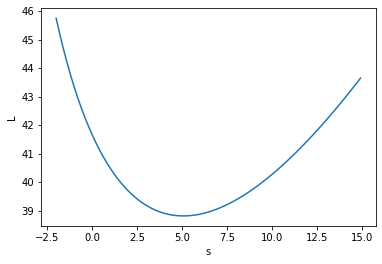

In [30]:
# Define the s scan
s_values = np.arange(-2, 15, 0.1)

# First define a python function to compute lambda(s) :
def lambda_s(s_val) :
    return sum( [ -2*np.log(scipy.stats.poisson.pmf(n, s_val*s_frac + b*b_frac)) for n, s_frac, b_frac in zip(data, s_fracs, b_fracs) ] )

# Compute the lambda(s) values for the scan points
lambda_values = np.array([ lambda_s(s_value) for s_value in s_values ]) # compute the likelihood (the Poisson PDF for each s)

# Plot the result
plt.plot(s_values, lambda_values)
plt.xlabel('s')
plt.ylabel('L')

# Find the maximum likelihood value in the list : merge the 2 lists and find the max based on the L value
from operator import itemgetter
print('hat{s}, ML =', min( [ (s,l) for s,l in zip(s_values, lambda_values) ], key=itemgetter(1)))

So the result is basically as expected, with a best-fit $\hat{s} \approx 5$. Of course this value is a bit imprecise due to the step size of 0.1 in the scan, but we can do better:

exact hat{s}: 5.063270689498512


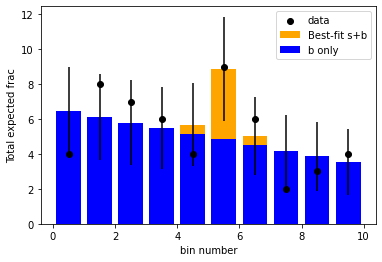

In [31]:
# Import the scipy minimization routine
from scipy.optimize import minimize_scalar

# Compute the value at minimum (.x selects the position of the minimum, .fun would return the function value)
s_hat = minimize_scalar(lambda_s, bounds=(0, 100)).x
print('exact hat{s}:', s_hat)

# Plot the result
best_fit_s_plus_b = s_hat*s_fracs + b*b_fracs
plt.bar(x, best_fit_s_plus_b, color='orange', yerr=np.sqrt(best_fit_s_plus_b), label='Best-fit s+b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected frac')
plt.legend();

So the best-fit value of $\hat{s}$ in this case is actually $5.06$ or so. Note than since $L(s)$ was defined only up to a multiplicative factor, $\lambda(s)$ is defined up to an additive constant, so the value $\lambda(\hat{s})$ at the minimum isn't meaningful. On the other hand, the difference between values of $\lambda(s)$ at different $s$ is meaningful, and will be used later in hypothesis testing.

## 3. Maximum-likelihood in the Gaussian case

We've seen that the Poisson distribution can often be well approximated by a Gaussian (and other distributions as well, though the Central-limit theorem). If we write the expected number of events as
$$
N_i = s f_{s,i} + b f_{b,i}
$$
then the likelihood is
$$
L(s) = \prod_{i=1}^{n_{\text{bins}}} P(n_i, N_i) \approx \prod_{i=1}^{n_{\text{bins}}} \exp\left(-\frac{1}{2} \frac{(n_i - N_i)^2}{\sigma_i^2} \right)
$$

And then the -2 log likelihood is

$$
\lambda(s) = -2 \log L(s) = \sum_{i=1}^{n_{\text{bins}}}\left(\frac{n_i - N_i}{\sigma_i}\right)^2
$$
which is of course very familiar: it's just the usual $\chi^2$. This is an important motivation for using $\lambda(s)$ : it can be defined for any likelihood, but in the Gaussian case, it reduces to the $\chi^2$. (Note that we've dropped the normalization factor of the Gaussian PDF along the way, but again, we're always free to drop constants when computing likelihoods)

The upshot is that for the Gaussian case, ML is the same as $\chi^2$ minimization -- this is why we're using "ML" and "best-fit" interchangeably in this notebook. To illustrate this, we can repeat the example above in the Gaussian case, now estimating $\hat{s}$ using the $\chi^2$.

For the standard $\chi^2$ (also called the *Pearson* $\chi^2$), we take $\sigma_i^2$ as the uncertainty on the prediction. Recall that for a Poisson distribution the variance is the same as the mean, so we have $\sigma_i^2 = N_i$.


exact hat{s}: 5.145208092109918


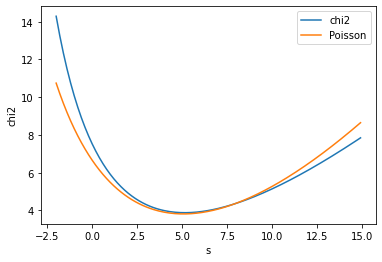

In [33]:
# Define a function to compute the chi2
def chi2_Pearson(s) :
    return sum( [ (n - (s*s_frac + b*b_frac))**2/(s*s_frac + b*b_frac) for n, s_frac, b_frac in zip(data, s_fracs, b_fracs) ] )


# Conmpute the chi2 values at the scan point and plot the results as before
chi2_values = np.array([ chi2_Pearson(s) for s in s_values ])
plt.plot(s_values, chi2_values, label='chi2')
plt.plot(s_values, lambda_values - 35, label='Poisson') # Shift the Poisson down to match the chi2
plt.xlabel('s')
plt.ylabel('chi2')
plt.legend();

# Compute the
print('exact hat{s}:', minimize_scalar(chi2_Pearson, (-2, 10)).x)

As expected, the (Pearson) $\chi^2$ is quite close to the Poisson case above (note that the Poisson curve is shifted down by an arbitrary amount, which we're always free to do for a log-likelihood). The difference comes from the fact that the event counts are not quite large enough for the Poisson distributions to be fully Gaussian, and the residual non-Gaussianity leads to a small discrepency between the exact Poisson model and its $\chi^2$ approximation.

One can have an even less Gaussian situation by setting $s$ and $b$ to smaller values (say $s=2$ and $b=1$), so that the number of events is not large enough to trigger the Central-limit theorem. In this case one should get an asymmetric shape for the Poisson $\lambda$ and sizable differences with the $\chi^2$ approximation. 

**The rest of this section is optional -- feel free to skip if you are short on time (you should be about half way through the session at this point)**

**Optional Exercise**

One can also define the alternate *Neyman* $\chi^2$, where the uncertainty is taken from the observation rather than the expectation, so $\sigma_i^2 = n_i$. This has some advantages, but typically agrees less well with the the Poisson limit:

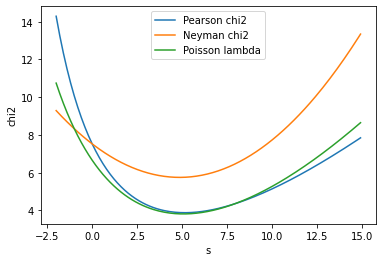

In [19]:
def chi2_Neyman(s) :
    return sum( [ (n - (s*s_frac + b*b_frac))**2/n for n, s_frac, b_frac in zip(data, s_fracs, b_fracs) ] )
chi2n_values = np.array([ chi2_Neyman(s) for s in s_values ]) # compute the chi2 for each s
plt.plot(s_values, chi2_values, label='Pearson chi2')
plt.plot(s_values, chi2n_values, label='Neyman chi2')
plt.plot(s_values, lambda_values - 35, label='Poisson lambda')
plt.xlabel('s')
plt.ylabel('chi2')
plt.legend();


## 4. Hypothesis testing basics

So far we've focused on estimating parameters, but to get realistic results (including setting uncertainties on the best-fit values), we need an additional ingredient, *hypothesis testing*. The procedure for this is as follows:
* **Define the hypotheses to test**. We need two of them: a baseline *null* hypothesis, and an *alternate* which is tested against it
* **Define the *test* to perform** -- meaning the observables to use, and procedure to decide which hypothesis to accept.
* **Compute the result of the test for the observed data**, in particular the *p-value* of the test, and decide whether to accept the null or the alternate hypothesis.

To start with, we consider a simple Poisson counting process
* Define two different signal hypotheses ($n=0$ and $n=5$)
* Define the test in terms of the observed number of events: if it is less than some threshold, accept the null $n=0$, otherwise $n=5$.
* As for any test, there are two ways to go wrong:
   * Rejecting the null although it is true (false positive): the fraction of such cases is the *Type-I error rate* or *p-value*.
   * Accepting the null although it is false (false negative) : : the fraction of such cases is the *Type-II error rate*, also (1 - Power)

A more stringent test reduces the Type-I error rate, but at the expense of an increased Type-II rate and vice versa. This is illustrated by the *ROC curve* which shows each error rate as a function of the other. The threshold for the test should be chosen depending on the desired balance between these error rates.

For the study below, we consider a single-bin counting experiment. In this case the disciminant is just the observed count $n$.

Text(0, 0.5, '1 - pvalue')

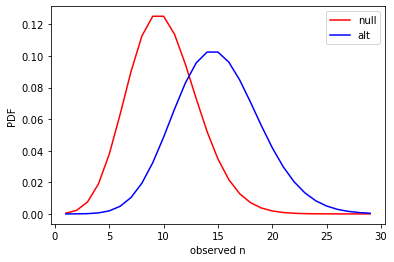

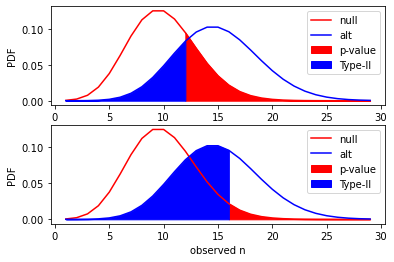

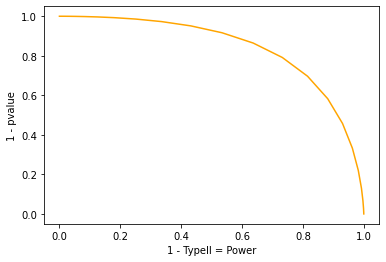

In [37]:
# Define the  hypotheses
b = 10 # background of 10 events
s_null = 0 # the null hypothesis: no signal, only background
s_alt  = 5 # the alternate hypothesis: 

# consider various values of the observed n (our discriminant)
ns = np.arange(1, 30, 1)

# Compute and plot the PDF values for the different n
# (note that applying scipy.stats.poisson.pmf to a list of values automatically returns the list of PDF values)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();

# A couple of plots illustrating different test configurations

# First a loose test with a threshold at n=12 (i.e s=2)
plt.figure()
plt.subplot(211)
threshold1 = 12
lo1 = np.arange( 1, threshold1 + 1, 1)
hi1 = np.arange(threshold1, 30, 1)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.fill_between(hi1, scipy.stats.poisson.pmf(hi1, s_null + b), color='r', label='p-value')
plt.fill_between(lo1, scipy.stats.poisson.pmf(lo1, s_alt  + b), color='b', label='Type-II')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();

# Now a more stringent test with a threshold at n=16 (i.e s=6)
plt.subplot(212)
threshold2 = 16
lo2 = np.arange( 1, threshold2 + 1, 1)
hi2 = np.arange(threshold2, 30, 1)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.fill_between(hi2, scipy.stats.poisson.pmf(hi2, s_null + b), color='r', label='p-value')
plt.fill_between(lo2, scipy.stats.poisson.pmf(lo2, s_alt  + b), color='b', label='Type-II')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();

# Now draw the ROC curve
thresholds = np.arange(1, 30, 1)
plt.figure()
plt.plot(scipy.stats.poisson.sf(thresholds, s_alt + b), scipy.stats.poisson.cdf(thresholds, s_null + b), color='orange')
plt.xlabel('1 - TypeII = Power')
plt.ylabel('1 - pvalue')

The threshold for discovery in physics is often set at the $5\sigma$ threshold, which corresponds to a p-value of about $3 \cdot 10^{-7}$. What threshold would one use to get so small a Type-I error rate ?

In [21]:
pfive = scipy.stats.norm.sf(5)
threshold_five = scipy.stats.poisson.isf(pfive, s_null + b)
print('pvalue=', pfive, 'threshold=', threshold_five, 'power=', scipy.stats.poisson.sf(threshold_five, s_alt + b))

pvalue= 2.866515718791933e-07 threshold= 29.0 power= 0.0004184496683276901


So if we observe $n_{\text{obs}} \ge 29$, then we can indeed reject the null at with a p-value corresponding to a $5\sigma$ threshold. This corresponds to testing for discovery: we reject the no-signal hypothesis in favor of an hypothesis with non-zero signal.

However the power of the test is also very low, which means that even if the $s=5$ signal is there, we are very unlikely to observe an event count of $n_{\text{obs}} \ge 29$. he underlying problem that is causing this is the fact that the different between the alternate hypothesis $s=5$ and the null $s=0$ is quite small on the scale of the measurement uncertainties, so the two hypotheses are difficult to separate.

If the alternate hypothesis was larger, say $20$ signal events, then things would be easier. The threshold for discovery would still be 29 events (this only depends on the null, not the alt), but now the power would be:

In [22]:
print(scipy.stats.poisson.sf(29, 20 + b))

0.52428301389368


i.e. this means that if $s_{\text{alt}} = 20$ is indeed true, then we have an approximately 50% chance of obtaining $n \ge 29$ and therefore of making the discovery.